# Import libraries and load dataset

In [1]:
# Use pandas to load data from a CSV file
import pandas as pd
# Use numpy for numerical operations
import numpy as np
# Use matplotlib for plotting
import matplotlib.pyplot as plt
# Use seaborn for enhanced plotting
import seaborn as sns
# Use ipaddress to convert IP to binary format
import ipaddress
# Use os for file path operations
import os

# Data Preprocessing
Create sampled dataset and train-test split datasets

In [2]:
# Specify path to directory of each malware class
malware_types = ['Adware','Benign','Ransomware','Scareware','SMSmalware']

# Each directory in malware_types contains nested directories of different families of malware of that type
# Each nested directory contains multiple CSV files of different samples of that family
# Load all families of data of each type of malware into a single dataframe
malware_data = {}
for malware_type in malware_types:
    malware_df = []
    for subdir in os.listdir(malware_type):
        subdir_path = os.path.join(malware_type, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(subdir_path, file)
                    df = pd.read_csv(file_path)
                    # Drop the old 'Label' column if it exists
                    if ' Label' in df.columns:
                        df.drop(columns=[' Label'], inplace=True)
                    df['Label'] = malware_type
                    malware_df.append(df)
    combined_malware_df = pd.concat(malware_df, ignore_index=True)
    malware_data[malware_type] = combined_malware_df

In [3]:
# Combine all malware dataframes into a single dataframe
combined_malware_df = pd.concat(malware_data.values(), ignore_index=True)

# Go through each column and remove whitespace from the column names
combined_malware_df.columns = combined_malware_df.columns.str.strip()

# Drop 'Flow ID' column
combined_malware_df.drop(columns=['Flow ID'], inplace=True)

# Drop the 'Timestamp' column
combined_malware_df.drop(columns=['Timestamp'], inplace=True)

# Convert IP fields to integer format
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return np.nan  # Handle invalid IP addresses

combined_malware_df['Source IP'] = combined_malware_df['Source IP'].apply(ip_to_int)
combined_malware_df['Destination IP'] = combined_malware_df['Destination IP'].apply(ip_to_int)

In [ ]:
# Print the first few rows of the combined dataframe to check the data
print(combined_malware_df.head())

In [4]:
# Print non-floating columns to check for any non-numeric data
non_float_columns = combined_malware_df.select_dtypes(exclude=[np.float64]).columns
print("Non-float columns:", non_float_columns)

# Check unique non-float values in the non-float columns, excluding 'Timestamp' and 'Label'
for col in non_float_columns:
    if col in ['Timestamp', 'Label']:
        continue
    unique_values = combined_malware_df[col].unique()
    for value in unique_values:
        if not isinstance(value, (int, float)):
            print(f"Column: {col}, Value: {value}, Type: {type(value)}")

Non-float columns: Index(['Flow IAT Min', 'Packet Length Std', 'CWE Flag Count', 'Down/Up Ratio',
       'Fwd Avg Bytes/Bulk', 'Label'],
      dtype='object')
Column: Flow IAT Min, Value: 37003, Type: <class 'str'>
Column: Flow IAT Min, Value: 37182, Type: <class 'str'>
Column: Flow IAT Min, Value: 37138, Type: <class 'str'>
Column: Flow IAT Min, Value: 36739, Type: <class 'str'>
Column: Flow IAT Min, Value: 37097, Type: <class 'str'>
Column: Flow IAT Min, Value: 37164, Type: <class 'str'>
Column: Flow IAT Min, Value: 37063, Type: <class 'str'>
Column: Flow IAT Min, Value: 37093, Type: <class 'str'>
Column: Flow IAT Min, Value: 38, Type: <class 'str'>
Column: Flow IAT Min, Value: 93, Type: <class 'str'>
Column: Flow IAT Min, Value: 287, Type: <class 'str'>
Column: Flow IAT Min, Value: 37, Type: <class 'str'>
Column: Flow IAT Min, Value: 37076, Type: <class 'str'>
Column: Flow IAT Min, Value: 107, Type: <class 'str'>
Column: Flow IAT Min, Value: 36647, Type: <class 'str'>
Column: Flow I

In [5]:
# For all string values in the non-float columns, excluding the 'Timestamp' and 'Label' columns, strip whitespace and try to typecast to float64
for col in non_float_columns:
    if col != 'Timestamp' and col != 'Label':
        combined_malware_df[col] = combined_malware_df[col].astype(str).str.strip()
        try:
            combined_malware_df[col] = combined_malware_df[col].astype(np.float64)
        except:
            # Replace the non-convertible values with 0
            combined_malware_df[col] = pd.to_numeric(combined_malware_df[col], errors='coerce').fillna(0)

# Print remaining unique non-float values in the non-float columns
for col in non_float_columns:
    if col in ['Timestamp', 'Label']:
        continue
    unique_values = combined_malware_df[col].unique()
    for value in unique_values:
        if not isinstance(value, (int, float)):
            print(f"Column: {col}, Value: {value}, Type: {type(value)}")

In [6]:
# Temporarily store the 'Label' column for later use
labels = combined_malware_df['Label'].copy()

In [ ]:
# Restore the 'Label' column to the combined dataframe (in case following block errors and does not restore it)
combined_malware_df['Label'] = labels

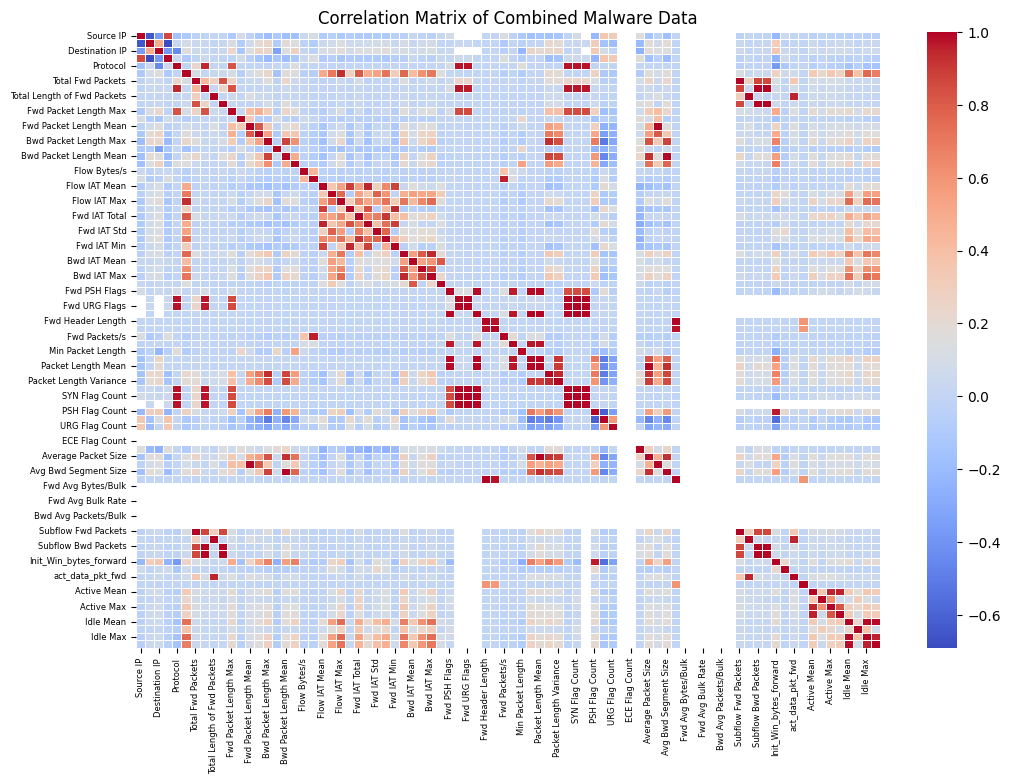

In [ ]:
# Drop the 'Label' column for correlation analysis
combined_malware_df.drop(columns=['Label'], inplace=True)

# Show the correlation matrix of the combined malware dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(combined_malware_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# Make the tick labels smaller
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix of Combined Malware Data')
plt.show()

# Restore the 'Label' column to the combined dataframe
combined_malware_df['Label'] = labels

In [8]:
# Print the column names of the combined dataframe
print("Column names in the combined dataframe:")
print(combined_malware_df.columns.tolist())

Column names in the combined dataframe:
['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Fl

In [7]:
# Select columns with high correlation or high negative correlation to reduce training time and complexity, or no correlation
drop_cols_no_corr = ['CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 
                     'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

drop_cols_nan_values = ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'RST Flag Count']

# Drop columns if they exist in the dataframe
for col in drop_cols_no_corr + drop_cols_nan_values:
    if col in combined_malware_df.columns:
        combined_malware_df.drop(columns=[col], inplace=True, errors='ignore')

In [8]:
# Restore the 'Label' column to the combined dataframe (in case following block errors and it needs to be restored)
combined_malware_df['Label'] = labels

In [9]:
# Drop columns with an absolute value correlation of 95% or higher with any other column

# Drop the 'Label' column for correlation analysis
combined_malware_df.drop(columns=['Label'], inplace=True)

# Compute the correlation matrix
corr_matrix = combined_malware_df.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find columns with correlation > max_correlation
max_correlation = 0.95
drop_cols = [column for column in upper.columns if any(upper[column] > max_correlation)]
cleaned_df = combined_malware_df.drop(columns=drop_cols, errors='ignore')

# Restore the 'Label' column to the cleaned dataframe
cleaned_df['Label'] = labels

In [ ]:
# Restore the 'Label' column to the cleaned dataframe (in case following block errors and it needs to be restored)
cleaned_df['Label'] = labels

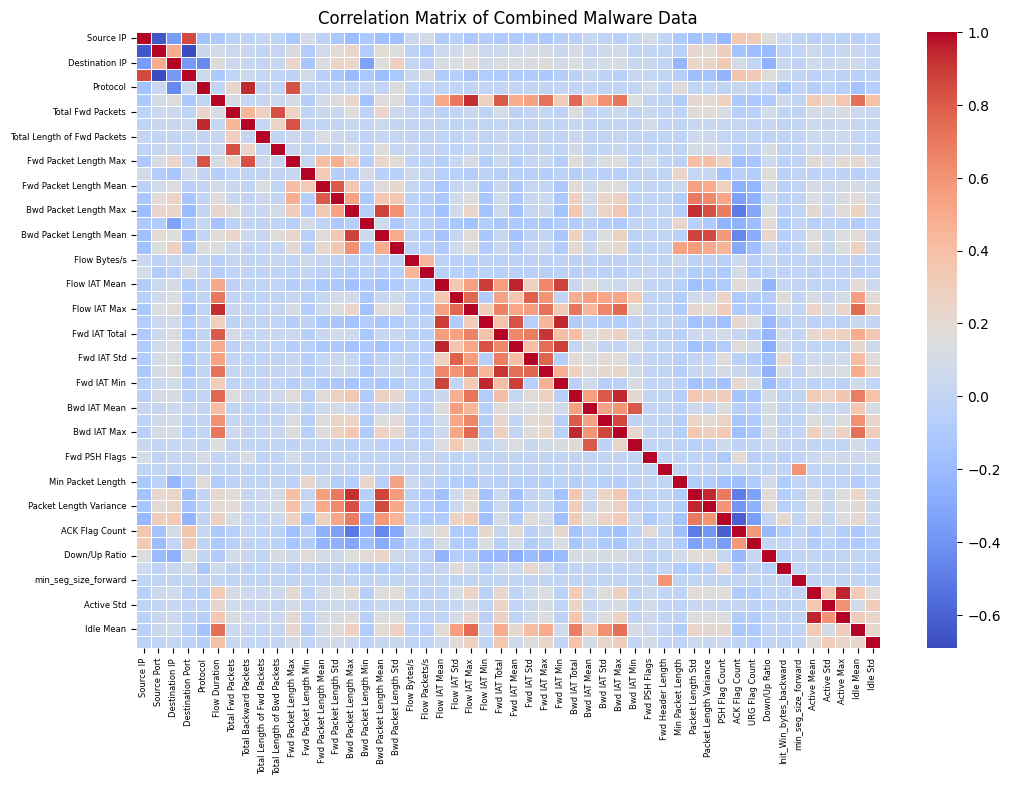

In [11]:
# Drop the 'Label' column for correlation analysis
cleaned_df.drop(columns=['Label'], inplace=True)

# Show the correlation matrix of the combined malware dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# Make the tick labels smaller
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix of Combined Malware Data')
plt.show()

# Restore the 'Label' column to the combined dataframe
cleaned_df['Label'] = labels

In [10]:
# Sample n rows from each malware type
num_samples = 2000
sampled_dfs = []
for malware_type in malware_types:
    sampled_df = cleaned_df[cleaned_df['Label'] == malware_type].sample(n=num_samples, random_state=42, replace=True)
    sampled_dfs.append(sampled_df)

# Concatenate the sampled dataframes into a single dataframe
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

In [11]:
# Print the number of samples for each malware type
print("Number of samples for each malware type:")
for malware_type in malware_types:
    count = sampled_df[sampled_df['Label'] == malware_type].shape[0]
    print(f"{malware_type}: {count} samples")

Number of samples for each malware type:
Adware: 2000 samples
Benign: 2000 samples
Ransomware: 2000 samples
Scareware: 2000 samples
SMSmalware: 2000 samples


In [12]:
# Save the sampled dataframe to a CSV file
output_file = 'sampled_malware_data_2k.csv'
sampled_df.to_csv(output_file, index=False)

In [2]:
# Load the sampled dataframe from the CSV file
output_file = 'sampled_malware_data_2k.csv'
sampled_df = pd.read_csv(output_file)

In [13]:
# Create the training and testing datasets
from sklearn.model_selection import train_test_split

# Split the data into features and labels
labels = sampled_df['Label']
data = sampled_df.drop(columns=['Label'])

# Split the data into training and testing sets
split_ratio = 0.8
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=1-split_ratio, random_state=42)

# Model Training

In [ ]:
# Implement a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Perform grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 50, 100, 200, 500],
    'min_samples_split': [20, 50, 100],
    'max_features': ['sqrt', 'log2', None],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_data, train_labels)

rf_classifier = grid_search.best_estimator_

# Make predictions on the test data
predictions = rf_classifier.predict(test_data)

# Print the classification report
print("Classification Report:")
print(classification_report(test_labels, predictions))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

      Adware       0.44      0.63      0.52      9912
      Benign       0.40      0.38      0.39      9938
  Ransomware       0.46      0.54      0.50     10036
  SMSmalware       0.46      0.35      0.40     10200
   Scareware       0.38      0.25      0.30      9914

    accuracy                           0.43     50000
   macro avg       0.43      0.43      0.42     50000
weighted avg       0.43      0.43      0.42     50000

Confusion Matrix:
[[6294  553 1627  569  869]
 [2045 3820 1606 1352 1115]
 [1790 1196 5468  840  742]
 [1769 2068 1572 3576 1215]
 [2508 1950 1575 1451 2430]]


In [11]:
# Print the hyperparameters of the best model
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 100, 'n_estimators': 100}


In [6]:
# Generate a dataset with only 1 of each malware type for training
malware_types = ['Adware', 'Benign', 'Ransomware', 'Scareware', 'SMSmalware']

# Create a new dataframe with only one sample of each malware type for training
unique_samples = []
for malware_type in malware_types:
    sample_df = sampled_df[sampled_df['Label'] == malware_type].sample(n=1, random_state=42)
    unique_samples.append(sample_df)

# Concatenate the unique samples into a single dataframe
unique_samples_df = pd.concat(unique_samples, ignore_index=True)

# Print the number of unique samples for each malware type
print("Number of unique samples for each malware type in the training set:")
for malware_type in malware_types:
    count = unique_samples_df[unique_samples_df['Label'] == malware_type].shape[0]
    print(f"{malware_type}: {count} sample")

# Split into training data and labels
train_labels = unique_samples_df['Label']
train_data = unique_samples_df.drop(columns=['Label'])

Number of unique samples for each malware type in the training set:
Adware: 1 sample
Benign: 1 sample
Ransomware: 1 sample
Scareware: 1 sample
SMSmalware: 1 sample


In [11]:
# Import SVM for classification
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# Train 5 one-vs-one SVM classifiers, one for each malware type
svm_classifiers = {}

for malware_type in malware_types:
    # Create binary labels for the current malware type vs all others
    binary_labels = np.where(train_labels == malware_type, 1, 0)
    
    # Train SVM classifier
    svm_classifier = LinearSVC(random_state=42)
    svm_classifier.fit(train_data, binary_labels)
    
    # Store the trained classifier
    svm_classifiers[malware_type] = svm_classifier

    # Save the trained SVM classifier to a file
    joblib.dump(svm_classifier, f'svm_classifier_{malware_type}.joblib')

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
# Use the classifiers in an ensemble approach to classify new samples
def ensemble_predict(sample, classifiers):
    votes = {malware_type: 0 for malware_type in malware_types}
    
    for malware_type, classifier in classifiers.items():
        prediction = classifier.predict(sample.reshape(1, -1))
        if prediction == 1:
            votes[malware_type] += 1
    
    # Return the malware type with the highest vote count
    return max(votes, key=votes.get)

# Test the ensemble approach on the training data
ensemble_predictions = []
for i in range(len(train_data)):
    sample = train_data.iloc[i].values
    predicted_type = ensemble_predict(sample, svm_classifiers)
    ensemble_predictions.append(predicted_type)

# Print the classification report for the ensemble predictions on the training data
print("Ensemble Classification Report on Training Data:")
print(classification_report(train_labels, ensemble_predictions))

# Print the confusion matrix for the ensemble predictions on the training data
print("Ensemble Confusion Matrix on Training Data:")
print(confusion_matrix(train_labels, ensemble_predictions))

Ensemble Classification Report on Training Data:
              precision    recall  f1-score   support

      Adware       1.00      1.00      1.00         1
      Benign       0.00      0.00      0.00         1
  Ransomware       1.00      1.00      1.00         1
  SMSmalware       0.50      1.00      0.67         1
   Scareware       1.00      1.00      1.00         1

    accuracy                           0.80         5
   macro avg       0.70      0.80      0.73         5
weighted avg       0.70      0.80      0.73         5

Ensemble Confusion Matrix on Training Data:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n